In [20]:
FileName='_0000001.img'

[Application],Enconding=UTF-8,Date="11/28/2023",Time="17:07:53",Software="HPD-TA",Application=2,ApplicationTitle="High Performance Digital Temporal Analyzer",SoftwareVersion="9.5 pf11",SoftwareDate="01.07.2021"
[Camera],CameraName="C13440-20C",SerialNumber="S/N: 306629",DCAMAPIVERSION="4.00",BUS="AS-FBD-1XCLD-2PE4L",VENDOR="Hamamatsu",CAMERAVERSION="4.31.C",DRIVERVERSION="8.13.30.6307",MODULEVERSION="21.7.4322.6307",Type=34,Binning="1",BinningKeyVal="2 x 2",ScanMode="2",ScanModeKeyVal="Subarray",HOffs="176",HWidth="672",VOffs="258",VWidth="508",TriggerMode="3",TriggerModeKeyVal="Internal",TriggerPolarity="1",TriggerPolarityKeyVal="neg.",ScanSpeed="2",Prop_SensorMode=1,Prop_ReadoutDirection=5,Prop_Colortype=1,Prop_BitPerChannel=16,Prop_TriggerGlobalExposure=5,Prop_TriggerConnector=2,Prop_TriggerTimes=1,Prop_TriggerDelay=0,Prop_InternalTriggerHandling=1,Prop_SensorCoolerStatus=2,Prop_DefectCorrectMode=2,Prop_HotPixelCorrectLevel=1,Prop_IntensityLutMode=1,Prop_IntensityLutPage=1,Prop_Extr

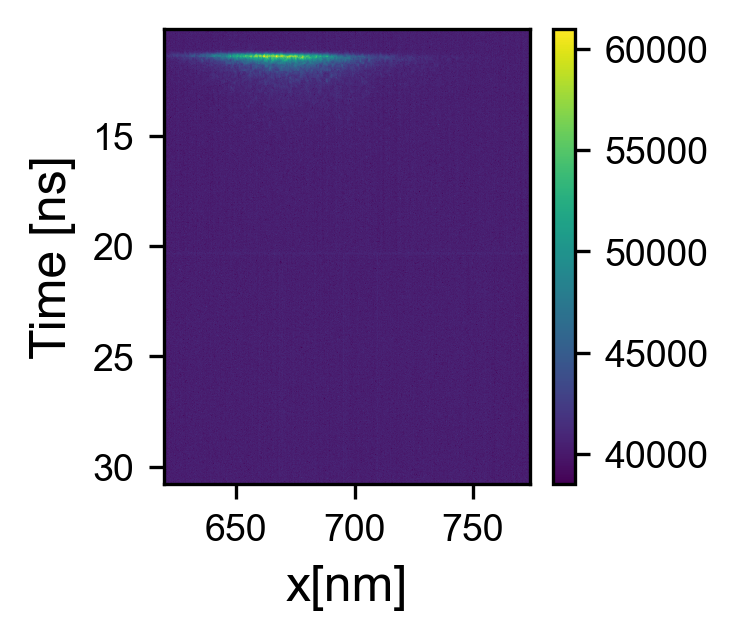

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
import os


########################
#Parameter
########################

BkgFileName='databkg.img'#change if bkg exist
verbose=True
cm = 1/2.54


########################
#Load and parse the file
########################
file=open(FileName,mode='rb')
data_raw=file.read()
IndexDataStart=np.frombuffer(data_raw[2:4], dtype=np.dtype('u2'))[0]+64

if verbose==True:
    print(data_raw[64:IndexDataStart].decode())

########################
#Recover image basic parameter
########################
BitDepth=np.frombuffer(data_raw[12:13], dtype=np.dtype('u1'))
BytesPerPixel=int(data_raw[data_raw.find(b'BytesPerPixel')+14: \
                                      data_raw.find(b'BytesPerPixel')+15].decode())

#It can't be that there is more than 2048 pixel which should then show as as 4 char
#so we split to only slect the right amount of character
ImgWidth=int(data_raw[data_raw.find(b'HWidth')+8: \
                                      data_raw.find(b'HWidth')+13].decode().split('"')[0])
ImgHeight=int(data_raw[data_raw.find(b'VWidth')+8: \
                                      data_raw.find(b'VWidth')+13].decode().split('"')[0])

IndexDataEnd=ImgWidth*ImgHeight*BytesPerPixel+IndexDataStart


print('Shape of image (widht x height): {}x{} px'.format(ImgWidth,ImgHeight))


########################
#Recover the unit for the different axis
########################

TimeUnit=data_raw[data_raw.find(b'ScalingYUnit'): \
                                      data_raw.find(b'ScalingYUnit')+18].decode().split('"')
XUnit=data_raw[data_raw.find(b'ScalingXUnit'): \
                                      data_raw.find(b'ScalingXUnit')+18].decode().split('"')

if TimeUnit[1]=='' :
    Time=np.linspace(-1,1,ImgHeight)
    TimeUnit[1]='a.u'
if XUnit[1]=='':
    x=np.linspace(-1,1,ImgWidth)
    XUnit[1]='a.u'
elif TimeUnit[1]=='a.u'  and XUnit[1]!='':
    print('a')
    x=np.frombuffer(data_raw[IndexDataEnd:], dtype=np.dtype('<f4'))
elif TimeUnit[1]!='' and XUnit[1]!='':
    print('b')
    temp=np.frombuffer(data_raw[IndexDataEnd:], dtype=np.dtype('<f4'))
    x=temp[0:ImgWidth]
    Time=temp[ImgWidth:]



########################
#Finally load the data
########################

if BytesPerPixel==4:
    Data= np.reshape(np.frombuffer(data_raw[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u4')), newshape=(ImgHeight, ImgWidth))
elif BytesPerPixel==2:
    Data= np.reshape(np.frombuffer(data_raw[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u2')), newshape=(ImgHeight, ImgWidth))

if os.path.isfile(BkgFileName):
    file=open(BkgFileName,mode='rb')
    data_raw_bkg=file.read()
    if BytesPerPixel==4:
        Databkg= np.reshape(np.frombuffer(data_raw_bkg[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u4')), newshape=(ImgHeight, ImgWidth))
    elif BytesPerPixel==2:
        Databkg= np.reshape(np.frombuffer(data_raw_bkg[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u2')), newshape=(ImgHeight, ImgWidth))
    Data=Data-Databkg

########################
#Fianlly we plot the data
########################

fig=plt.figure(figsize=(5*cm,5*cm))
ax0 =plt.subplot(1,1,1)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})
im=ax0.pcolormesh(x,Time,Data)

ax0.set_ylabel('Time [{}]'.format(TimeUnit[1]))
ax0.set_xlabel('x[{}]'.format(XUnit[1]))
ax0.invert_yaxis()
fig.colorbar(im)
print(np.max(Data))



In [4]:
print(IndexDataEnd-IndexDataStart)
temp=np.argmax(np.max(Data,axis=0))


1365504


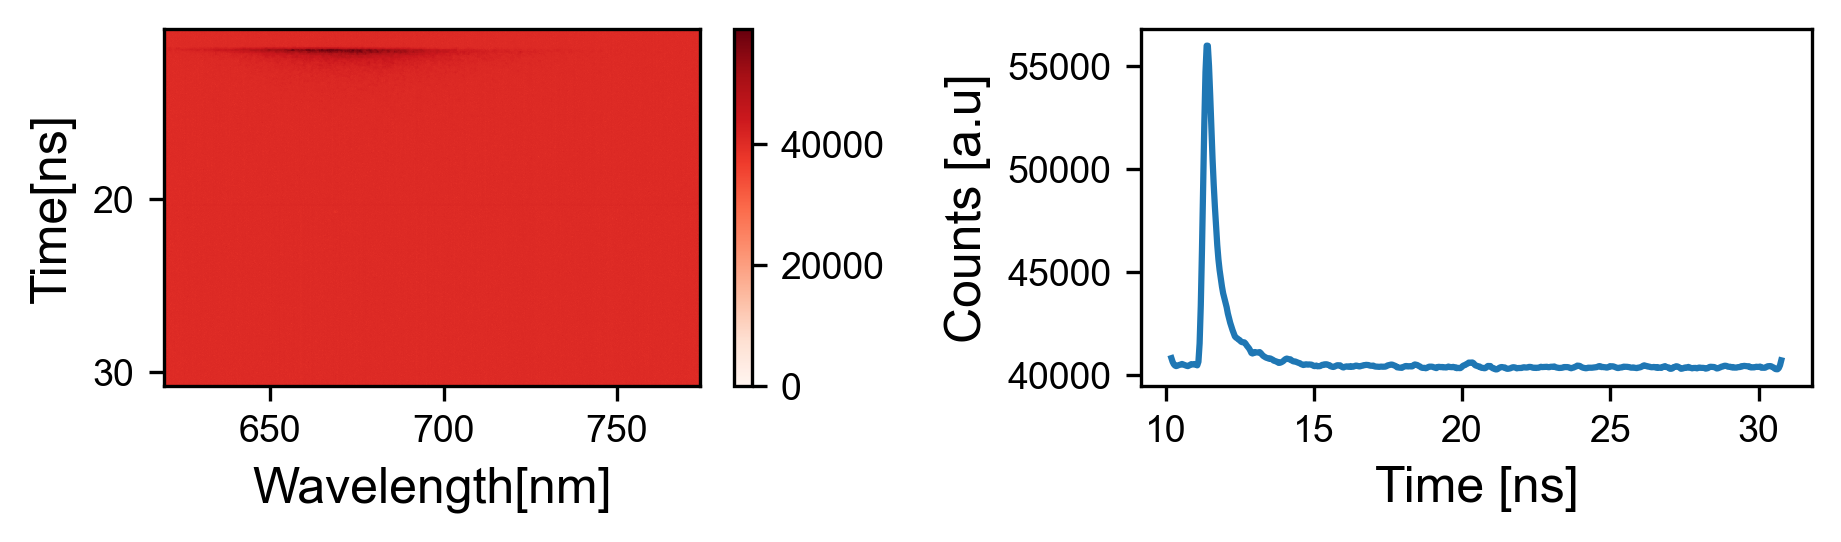

In [18]:
import glob
from scipy.signal import savgol_filter
c='plasma'
fig1=plt.figure(figsize=(16*cm,5*cm))
ax1 =plt.subplot(1,2,1)
#ax2 =plt.subplot(1,3,2)
ax3 =plt.subplot(1,2,2)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})

im2=ax1.pcolormesh(x,Time,Data,cmap='Reds',vmin=0)
ax1.set_ylabel('Time [{}]'.format(TimeUnit[1]))
ax1.set_xlabel('x[{}]'.format(XUnit[1]))
ax1.invert_yaxis()
plt.colorbar(im2,ax=ax1)


#Now we only look for the maximum value
wmax=np.unravel_index(Data[:,:].argmax(), Data[:,:].shape)[1]
ax3.plot(Time,savgol_filter(np.mean(Data[:,wmax-5:wmax+5],1), 10, 3))

ax1.set_ylabel('Time[ns]', wrap=True)
ax1.set_xlabel('Wavelength[nm]')

ax3.set_ylabel('Counts [a.u]', wrap=True)
ax3.set_xlabel('Time [ns]')

plt.tight_layout()
plt.savefig("Data.png")



# Fitting  lifetime


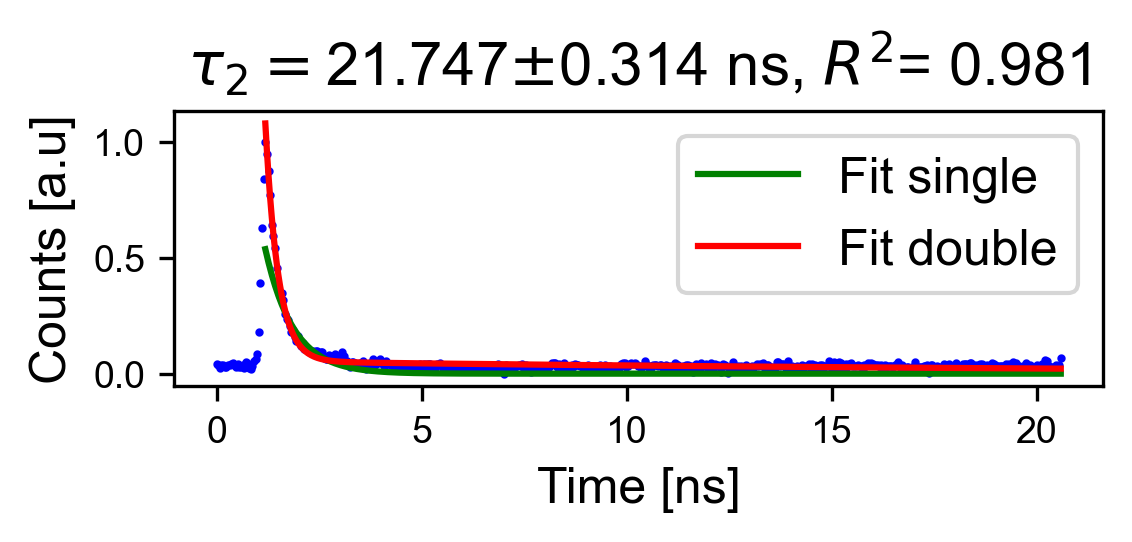

In [6]:
from scipy.optimize import curve_fit
from scipy.stats import chisquare

ScalingParameter=[0.1,1,0.1,1,0.1,1]
########################
#Plotting
########################

fig1=plt.figure(figsize=(10*cm,5*cm))
ax1 =plt.subplot(1,1,1)


mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})

def TriexpFunc(x,a,b,c,d,e,f):
    return np.array(a*ScalingParameter[0] * np.exp( -(x/(b*ScalingParameter[1]))) +
                    c*ScalingParameter[2] * np.exp( -(x/(d*ScalingParameter[3])))+
                    e*ScalingParameter[4] * np.exp( -(x/(f*ScalingParameter[5]))),dtype='float32')

def BiexpFunc(x,a,b,c,d):
    return np.array(a*ScalingParameter[0] * np.exp( -(x/(b*ScalingParameter[1]))) +
                    c*ScalingParameter[2] * np.exp( -(x/(d*ScalingParameter[3]))),dtype='float32')

def expFunc(x,a,b):
    return np.array(a*ScalingParameter[0] * np.exp(-(x/(b*ScalingParameter[1]))),dtype='float32') 

data=np.mean(Data[:,wmax-1:wmax+1],1)
index_max=data.tolist().index(max(data))

Time_fit=Time[index_max:]-Time[index_max]
Data_fit=(data[index_max:]-np.min(data[index_max:]))
Data_fit=Data_fit/np.max(Data_fit)

########################
#Exp fit
########################

popt, pcov = curve_fit(expFunc,Time_fit,Data_fit)
curveye = expFunc(Time_fit,popt[0],popt[1]) # This is your y axis fit-line

########################
#Bi exp fit
########################
#p0=[popt[0],popt[1],1.0,-1/25]

#popt, pcov = curve_fit(TriexpFunc,Time_fit,Data_fit,p0=[popt[0]/ScalingParameter[0],popt[1]/ScalingParameter[1],1,2,1,2])
popt, pcov = curve_fit(BiexpFunc,Time_fit,Data_fit,p0=[popt[0]/ScalingParameter[0],popt[1]/ScalingParameter[1],1,2])

curvey = BiexpFunc(Time_fit,popt[0],popt[1],popt[2],popt[3]) # This is your y axis fit-line
LifeTimeError=np.sqrt(np.diag(pcov)[3]/ScalingParameter[3])


Rsq=1-(np.sum(np.power(Data_fit-curvey,2)))/(np.sum(np.power(Data_fit-np.mean(Data_fit),2)))

ax1.plot(Time_fit+Time[index_max]-np.min(Time), curveye, 'green', label='Fit single')
ax1.plot(Time_fit+Time[index_max]-np.min(Time), curvey, 'red', label='Fit double')
ax1.scatter(Time-np.min(Time),(data-np.min(data[index_max:]))/np.max(data-np.min(data)), c='b',s=1)

ax1.set_title('$\\tau _2=${}$\pm${} ns, $R^2$= {}'.format(
    str(np.round(popt[3]/ScalingParameter[3],decimals=3)),np.round(LifeTimeError,decimals=3),np.round(Rsq,decimals=3)))
ax1.set_ylabel('Counts [a.u]', wrap=True)
ax1.set_xlabel('Time [ns]')
ax1.legend()
plt.tight_layout()
plt.savefig("Fit.png")

# Fitting lifetime for all wavelength 

In [7]:
from scipy.optimize import curve_fit


ScalingParameter=[0.1,1,0.1,1]

def BiexpFunc(x,a,b,c,d):
    return np.array(a*ScalingParameter[0] * np.exp( -(x/(b*ScalingParameter[1]))) +
                    c*ScalingParameter[2] * np.exp( -(x/(d*ScalingParameter[3]))),dtype='float32')

def expFunc(x,a,b):
    return np.array(a*ScalingParameter[0] * np.exp(-(x/(b*ScalingParameter[1]))),dtype='float32') 


nb_wave=Data.shape[1]
lifetime=np.zeros(nb_wave)
gof=lifetime
lifetime.fill(None)
for idx in range(0,nb_wave):
    data=Data[:,idx]/np.max(Data[:,idx])
    index_max=data.tolist().index(max(data))


    Time_fit=Time[index_max:]-np.min(Time[index_max])
    Data_fit=(data[index_max:]-np.min(data[index_max:]))
    Data_fit=Data_fit/np.max(Data_fit)

    try:
        ########################
        #Exp fit
        ########################
        popt, pcov = curve_fit(expFunc,Time_fit,Data_fit)
        curveye = expFunc(Time_fit,popt[0],popt[1]) # This is your y axis fit-line
        

        ########################
        #Bi exp fit
        ########################

        popt, pcov = curve_fit(BiexpFunc,Time_fit,Data_fit,p0=[popt[0]/ScalingParameter[0],popt[1]/ScalingParameter[1],1,2])
        curvey = BiexpFunc(Time_fit,popt[0],popt[1],popt[2],popt[3]) # This is your y axis fit-line
    except RuntimeError:
        print('Could not fit')
        continue
    except:
        print('Other problem')
        continue

    residuals = Data_fit - curvey

    fres = sum( np.divide(np.power(residuals,2),curvey*curvey) )/415
    gof[idx]=fres
    lifetime[idx]=popt[3]/ScalingParameter[3]


Other problem


d:\Python\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\gautier\AppData\Local\Temp\ipykernel_9728\3786740238.py:7: RuntimeWarning: overflow encountered in cast
  return np.array(a*ScalingParameter[0] * np.exp( -(x/(b*ScalingParameter[1]))) +
C:\Users\gautier\AppData\Local\Temp\ipykernel_9728\3786740238.py:25: RuntimeWarning: invalid value encountered in divide
  Data_fit=Data_fit/np.max(Data_fit)


Other problem
Other problem
Other problem
Other problem
Other problem
Other problem
Other problem
Other problem


C:\Users\gautier\AppData\Local\Temp\ipykernel_9728\3786740238.py:8: RuntimeWarning: overflow encountered in exp
  c*ScalingParameter[2] * np.exp( -(x/(d*ScalingParameter[3]))),dtype='float32')


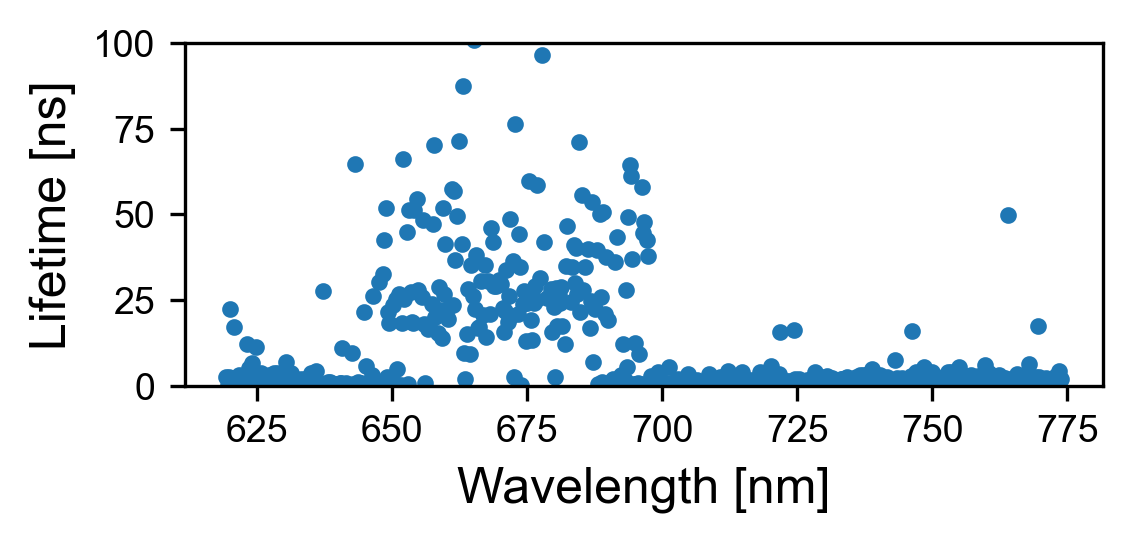

In [8]:
fig1=plt.figure(figsize=(10*cm,5*cm))
ax1 =plt.subplot(1,1,1)
#ax2 = ax1.twinx() 

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})
lifetime_c=lifetime
lifetime_c[lifetime<0]=-100
ax1.plot(x,lifetime_c,'.')

ax1.set_ylim([0,100])
ax1.set_ylabel('Lifetime [ns]', wrap=True)
ax1.set_xlabel('Wavelength [nm]')
plt.tight_layout()
plt.savefig("LifevsWave.png")


# Beauty shot TRPL

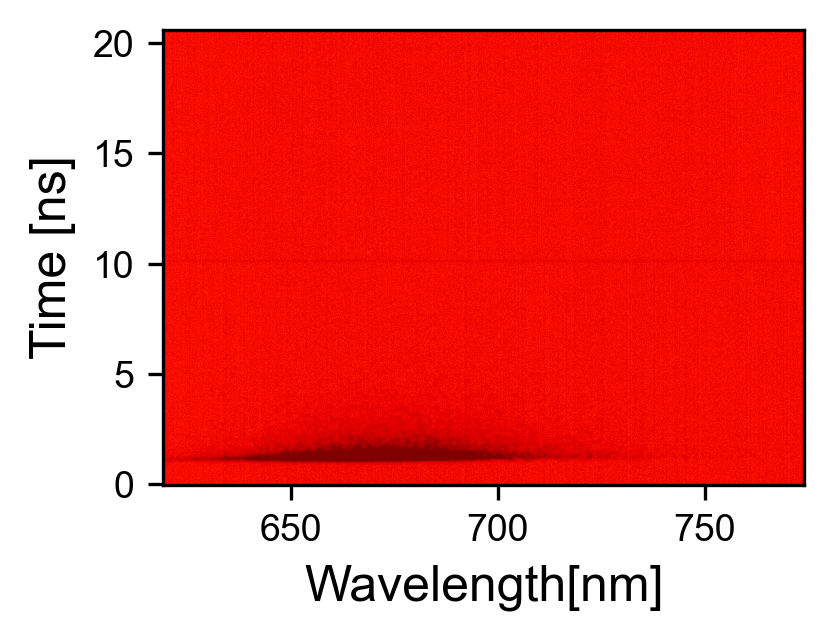

In [19]:
data=np.zeros(Data.shape)
import pandas as pd
import scipy.ndimage as ndimage

data=pd.DataFrame(Data)
#for idx in range(0,Data.shape[0]):
#    data[idx,:]=savgol_filter(Data[idx,:], 6, 2)
temp=ndimage.gaussian_filter(data,sigma=(0,3))
temp=data
fig1=plt.figure(figsize=(7*cm,5*cm))
ax1 =plt.subplot(1,1,1)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})

im2=ax1.pcolormesh(x,Time-min(Time),temp,cmap='jet',vmin=0, vmax=45000)
ax1.set_ylabel('Time [{}]'.format(TimeUnit[1]))
ax1.set_xlabel('Wavelength[{}]'.format(XUnit[1]))
plt.savefig("RawLifetimeGaussianFilter.png")

# Follow kinetics

## Load the data

In [10]:
import glob
import scipy.ndimage as ndimage
Folder='./'
DataNameBasis='/'

File=glob.glob(Folder+DataNameBasis+"*.img")
Data_kin=np.zeros([len(File),ImgHeight,ImgWidth])
Data_gif=np.zeros([len(File),ImgHeight,ImgWidth])
TimeExp=np.zeros([len(File),1])
images = []

for i,File_temp in enumerate(File):
    file=open(File_temp,mode='rb')
    data_raw_kin=file.read()
    IndexDataStart=np.frombuffer(data_raw_kin[2:4], dtype=np.dtype('u2'))[0]+64
    IndexDataEnd=ImgWidth*ImgHeight*BytesPerPixel+IndexDataStart
    
    TimeTemp=data_raw_kin[data_raw_kin.find(b'Time'): \
                                      data_raw_kin.find(b'Time')+16].decode().split('"')
    #print(TimeTemp)
    try:
        TimeExp[i]=int(TimeTemp[1].split(':')[0])*3600+int(TimeTemp[1].split(':')[1])*60+int(TimeTemp[1].split(':')[2])
    except:
        if i==1:
            TimeExp[0]=0
        TimeExp[i]=float(TimeTemp[1].split('ms')[0])
    if BytesPerPixel==4:
        temp=np.reshape(np.frombuffer(data_raw_kin[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u4')), newshape=(ImgHeight, ImgWidth))
    elif BytesPerPixel==2:
        temp=np.reshape(np.frombuffer(data_raw_kin[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u2')), newshape=(ImgHeight, ImgWidth))
    Data_kin[i,:,:]=temp
    Data_gif[i,:,:]=ndimage.gaussian_filter( np.squeeze(Data_kin[i,:,:]),sigma=(0,3))

TimeExp=np.round(TimeExp-TimeExp[0],0)/1000

## Create a gif of the kinetics

MovieWriter ffmpeg unavailable; using Pillow instead.


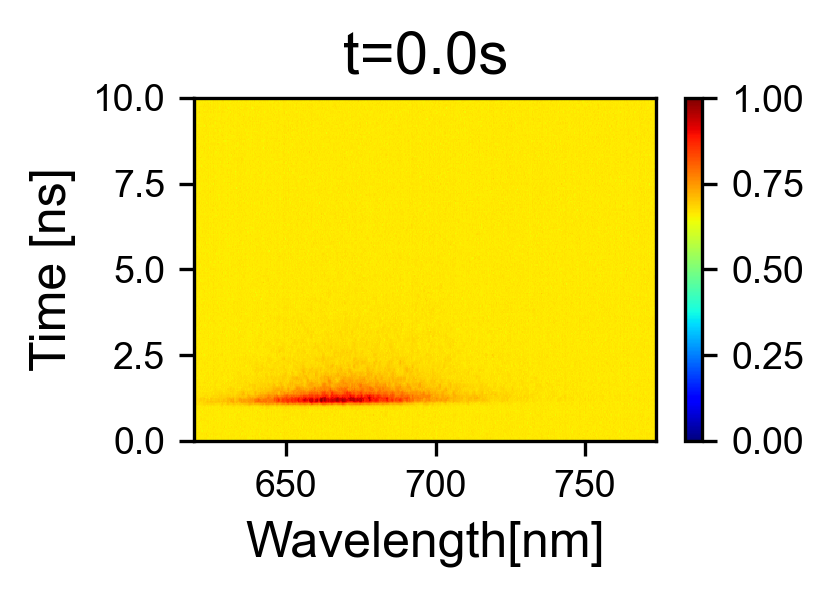

In [11]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
fig1=plt.figure(figsize=(7*cm,5*cm))
ax1 =plt.subplot(1,1,1)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})

maxI0=np.max(Data_kin[0,:,:])
im2=ax1.pcolormesh(x,Time-min(Time),Data_kin[0,:,:]/maxI0,cmap='jet',vmin=0, vmax=1)
ax1.set_ylabel('Time [{}]'.format(TimeUnit[1]))
ax1.set_xlabel('Wavelength[{}]'.format(XUnit[1]))
ax1.set_ylim([0,10])
plt.colorbar(im2,ax=ax1)
plt.tight_layout()

def animate(i):
    ax1.set_title('t={}s'.format(TimeExp[i].squeeze())) 
    im2.set_array((Data_kin[i,:,:]/maxI0))

ani = animation.FuncAnimation(fig1, animate, interval=100, frames=50) 
ani.save("Lifetime.gif")

## Follow the kinetics (Bi-exponential Fit)

d:\Python\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


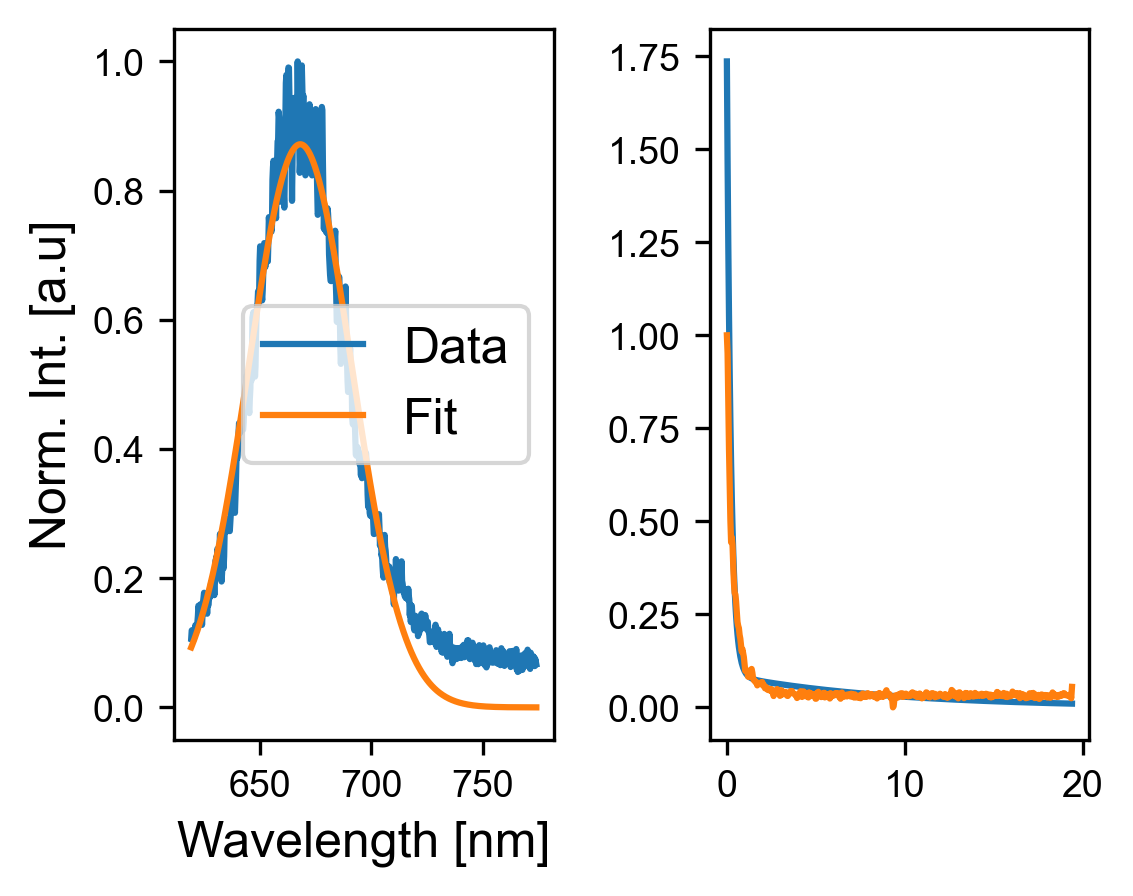

In [14]:
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import pandas as pd


ScalingParameter=[0.1,1,0.1,1]
ScalingParameterG=[1,100,10]
R_value=0.95

def BiexpFunc(x,a,b,c,d):
	return np.array(a*ScalingParameter[0] * np.exp( -(x/(b*ScalingParameter[1]))) +
					c*ScalingParameter[2] * np.exp( -(x/(d*ScalingParameter[3]))),dtype='float32')

def expFunc(x,a,b):
	return np.array(a*ScalingParameter[0] * np.exp(-(x/(b*ScalingParameter[1]))),dtype='float32') 

def Gaussian(x,a,b,c):
	return np.array(a*ScalingParameterG[0] * np.exp(-0.5*np.power((x-b*ScalingParameterG[1])/(c*ScalingParameterG[2]),2)),dtype='float32') 

File=glob.glob(Folder+DataNameBasis+"*.img")





LifetimePeak=np.empty(len(File)-1)
ErrorLifetimePeak=np.empty(len(File)-1)
WavePeak=np.empty(len(File)-1)
Max_int_Theoritical=np.empty(len(File)-1)
Max_int=np.empty(len(File)-1)
Rsq_kin=np.empty(len(File)-1)
FittedLifetimeTrace=pd.DataFrame(np.empty([len(File)-1,len(Time)]))

fig1=plt.figure(figsize=(10*cm,8*cm))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
					 'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})

# dim= [exp, time wave]
for i,File_temp in enumerate(File[:-1]):

	Time_max_index=np.unravel_index(Data_kin[i,:,:].argmax(), Data_kin[i,:,:].shape)[0]
	#First we try to fit to a gaussian to find the center of the peak 
	data_temp_kin=np.squeeze(np.mean(Data_kin[i,Time_max_index-5:Time_max_index+5,:]-np.min(Data_kin[i,Time_max_index-5:Time_max_index+5,:]),0))
	if i==0:
		IntNorma=np.max(data_temp_kin)
	try:
		########################
		#Gaussian fit
		########################

		popt, pcov = curve_fit(Gaussian,x,data_temp_kin/IntNorma,p0=[1,6.30,5.0])
		curvey = Gaussian(x,popt[0],popt[1],popt[2])
		if i==0:
			ax1.plot(x,data_temp_kin/np.max(data_temp_kin),label='Data')
			ax1.plot(x,curvey,label='Fit')

		Max_int_Theoritical[i]=np.max(curvey)
		Max_int[i]=np.max(Data_fit)
		WavePeak[i]=popt[1]*ScalingParameterG[1]

	except RuntimeError:
		print('Could not fit')
		continue
	except ValueError:
		continue


	# We now take a slice in time at the theoritical maximum and try to fit a biexponential to it
	temp=Data_kin[i,:,np.abs(x-WavePeak[i]).argmin()-5:np.abs(x-WavePeak[i]).argmin()+5]
	data_temp_kin=np.squeeze((np.mean(temp,1)-np.min(np.mean(temp,1)))/np.max(np.mean(temp,1)))

	index_max=data_temp_kin.tolist().index(max(data_temp_kin))


	Time_fit=Time[index_max:]-np.min(Time[index_max])
	Data_fit=data_temp_kin[index_max:]/np.max(data_temp_kin[index_max:])

	try:
		########################
		#Exp fit
		########################

		popt, pcov = curve_fit(expFunc,Time_fit,Data_fit)
		

		########################
		#Bi exp fit
		########################
		popt, pcov = curve_fit(BiexpFunc,Time_fit,Data_fit,p0=[[popt[0]/ScalingParameter[0],popt[1]/ScalingParameter[1],1,2]])
		curvey = BiexpFunc(Time_fit,popt[0],popt[1],popt[2],popt[3]) # This is your y axis fit-line
		if i==0:
			ax2.plot(Time_fit,curvey)
			ax2.plot(Time_fit,Data_fit)
		
		if popt[3]>0:
			LifetimePeak[i]=popt[3]/ScalingParameter[3]
			ErrorLifetimePeak[i]=np.sqrt(np.diag(pcov)[3]/ScalingParameter[3])
			Rsq_kin[i]=1-(np.sum(np.power(Data_fit-curvey,2)))/(np.sum(np.power(Data_fit-np.mean(Data_fit),2)))
			if Rsq_kin[i]<R_value:
				LifetimePeak[i]=None
				ErrorLifetimePeak[i]=None
			

	except RuntimeError:
		print('Could not fit')
		LifetimePeak[i]=None
		ErrorLifetimePeak[i]=None

		continue
	except Exception as e:
		print(e)
		continue


ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Norm. Int. [a.u]')
ax1.legend()
plt.tight_layout()
#plt.savefig("GaussianFit.png")

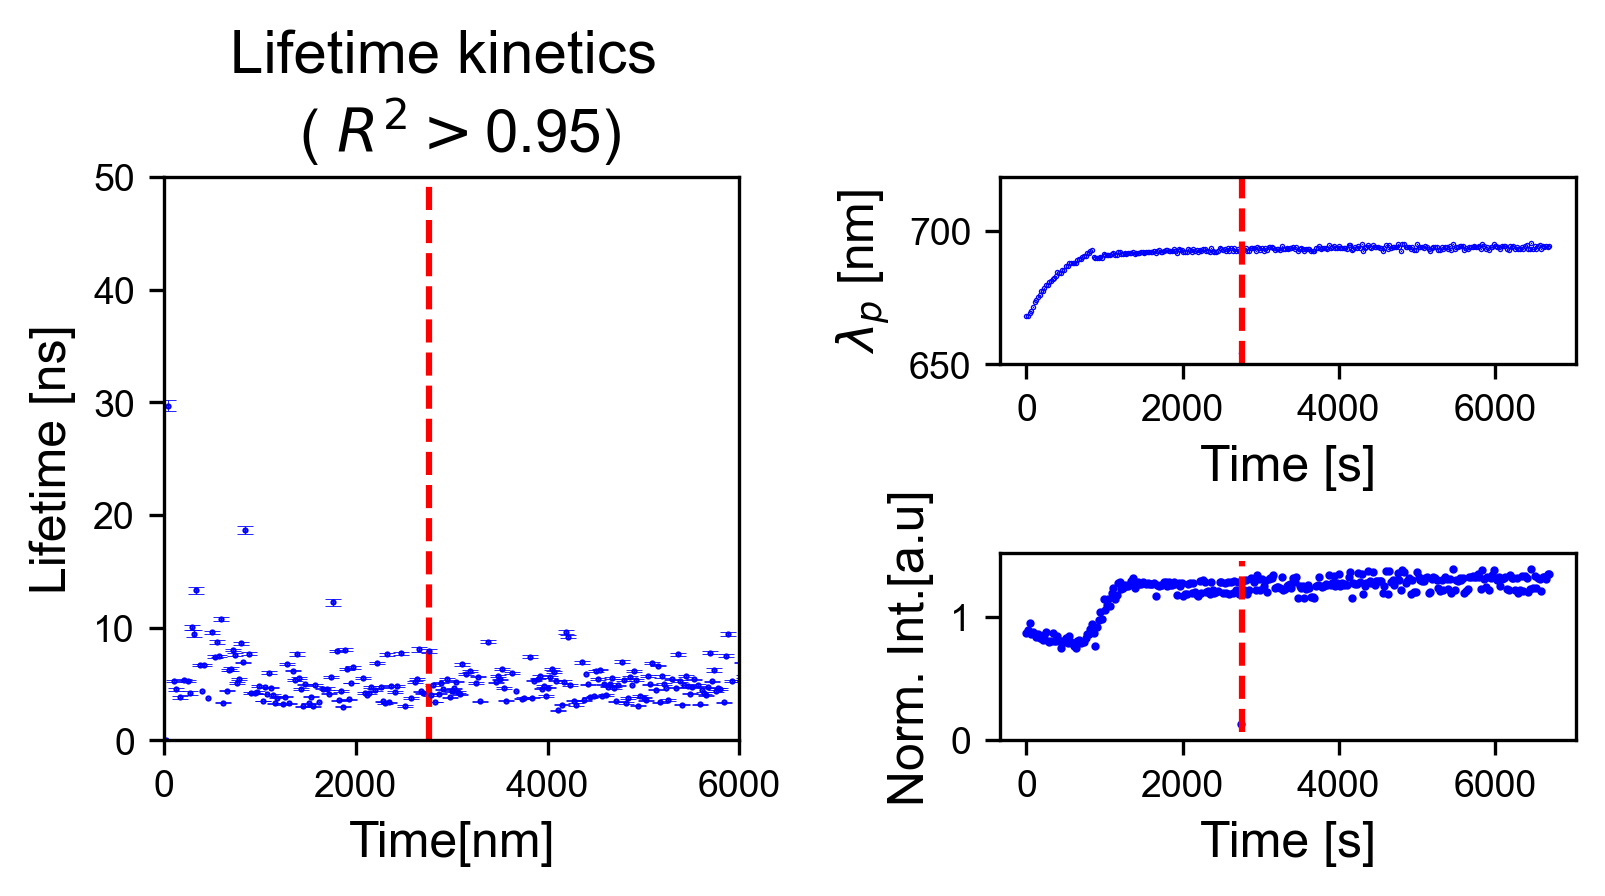

In [15]:
# We can compute change in dynamics

dlp=np.gradient(WavePeak,TimeExp[:-1].squeeze())
dlp2=np.gradient(dlp,TimeExp[:-1].squeeze())
ValueChangeDynamics=TimeExp[np.argmax(dlp)]


fig1 = plt.figure(figsize=(14*cm,8*cm))

ax1= plt.subplot(1,2,1)
ax2= plt.subplot(2,2,2)
ax3= plt.subplot(2,2,4)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})


#ax1.scatter(TimeExp[:-1],LifetimePeak,s=1,color='blue')
ax1.errorbar(TimeExp[:-1],LifetimePeak,yerr=ErrorLifetimePeak,capsize=2,fmt='.',color='blue',elinewidth=0.2,capthick=0.2,markersize=1)
ax1.set_ylabel('Lifetime [{}]'.format(TimeUnit[1]))
ax1.set_xlabel('Time[{}]'.format(XUnit[1]))
ax1.set_ylim([0,50])
ax1.set_xlim([0,6000])
ax1.set_title('Lifetime kinetics \n ( $R^2>${})'.format(R_value))
ax1.plot([ValueChangeDynamics,ValueChangeDynamics],ax1.get_ylim(),'--',color='r')

ax2.scatter(TimeExp[:-1],WavePeak,s=0.1,label='$\lambda_{p}$',color='blue')
ax2.set_ylim([650,720])
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('$\lambda_{p}$ [nm]')
ax2.plot([ValueChangeDynamics,ValueChangeDynamics],ax2.get_ylim(),'--',color='r')
#ax2.set_title('Wavelength shift')

ax3.scatter(TimeExp[:-1],Max_int_Theoritical,s=1,edgecolors='blue',label='$I_{max}$')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Norm. Int.[a.u]',wrap=True)
ax3.plot([ValueChangeDynamics,ValueChangeDynamics],ax3.get_ylim(),'--',color='r')
#ax3.set_title('Evolution of intensity')

plt.tight_layout()
plt.savefig("KineticsLifetime.png")



# Differential  lifetime analysis